In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [4]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [8]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)
    plt.show()

In [7]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [34]:
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

In [52]:
def plot_2d(alphas, bs, filenames, last, keys, names, add_tiks=False):
    fig, grid = plt.subplots(nrows=len(names), ncols=len(keys), figsize=(3 * len(keys), 2.5 * len(names)), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    cur_letter = 0
    LIMS_BY_KEY = {'rho': (0., 1.), 'stdrho': (0., .05), 'l': (0, .07)}
    TIKS_BY_KEY = {'rho': [.1, .5, .9],
                  'stdrho': [.01, .02, .03, .04],
                  'l': [.01, .03, .05]}
    LVLS_BY_KEY = {'rho': [.5, .7, .9],
                  'stdrho': [.03],
                  'l': []}
    
    for name, filename, axs, row_id in zip(names, filenames, grid, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
        for key, ax, col_id in zip(keys, axs, range(len(keys))):
            if key.startswith('std'):
                cur = np.apply_along_axis(lambda x: np.std(x[-last:]), 3, data[key[3:]])
            else:
                cur = np.apply_along_axis(lambda x: np.mean(x[-last:]), 3, data[key])
            cur = np.apply_along_axis(np.mean, 0, cur)

            CSF = ax.contourf(bs, alphas, cur, levels=100, label=str(key),
                             vmin=LIMS_BY_KEY[key][0], vmax=LIMS_BY_KEY[key][1],
                             # cmap=cm.coolwarm,
                             )
            if add_tiks and LVLS_BY_KEY[key]:
                CS = ax.contour(bs, alphas, cur, levels=LVLS_BY_KEY[key], colors='black', linestyles='dashed')
                plt.clabel(CS, fmt='%1.1f', colors='k', fontsize=14)  # contour line labels

            if row_id == 0:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("top", size="5%", pad=0.05)
                m = plt.cm.ScalarMappable(
                #    cmap=cm.coolwarm
                )
                m.set_array(cur.flatten)
               
                m.set_clim(*LIMS_BY_KEY[key])
                cb = fig.colorbar(m, cax=cax, orientation='horizontal', 
                                  # fraction=.1,
                                  ticklocation='top',
                                  ticks=TIKS_BY_KEY[key],
                                  # norm=mpl.colors.Normalize(vmin=0, vmax=1)
                                  # boundaries=[0, 1]
                                 )
                # cb.ax.locator_params(nbins=3)

                TITLE_BY_KEY = {'rho': r'$\rho$', 'stdrho': r'$\sigma_{\rho}$', 'l': r'$l$'}
                cax.set_title(TITLE_BY_KEY[key])

            if row_id == len(names) - 1:
                ax.set_xlabel(r'$b$')
            
            if col_id == 0:
                ax.set_ylabel(r'$\alpha$')
                first_col = False
                
            ax.text(.1, .9, chr(ord('a') + cur_letter),
                    fontdict={'color': 'white', 'size': 16},
                    horizontalalignment='center',
                    transform=ax.transAxes)
            cur_letter += 1
            
            if col_id == len(keys) - 1:
                ax.text(1.2, .8, name,
                       fontdict={'color': 'black', 'size': 24},
                       horizontalalignment='center',
                       transform=ax.transAxes)
            # ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


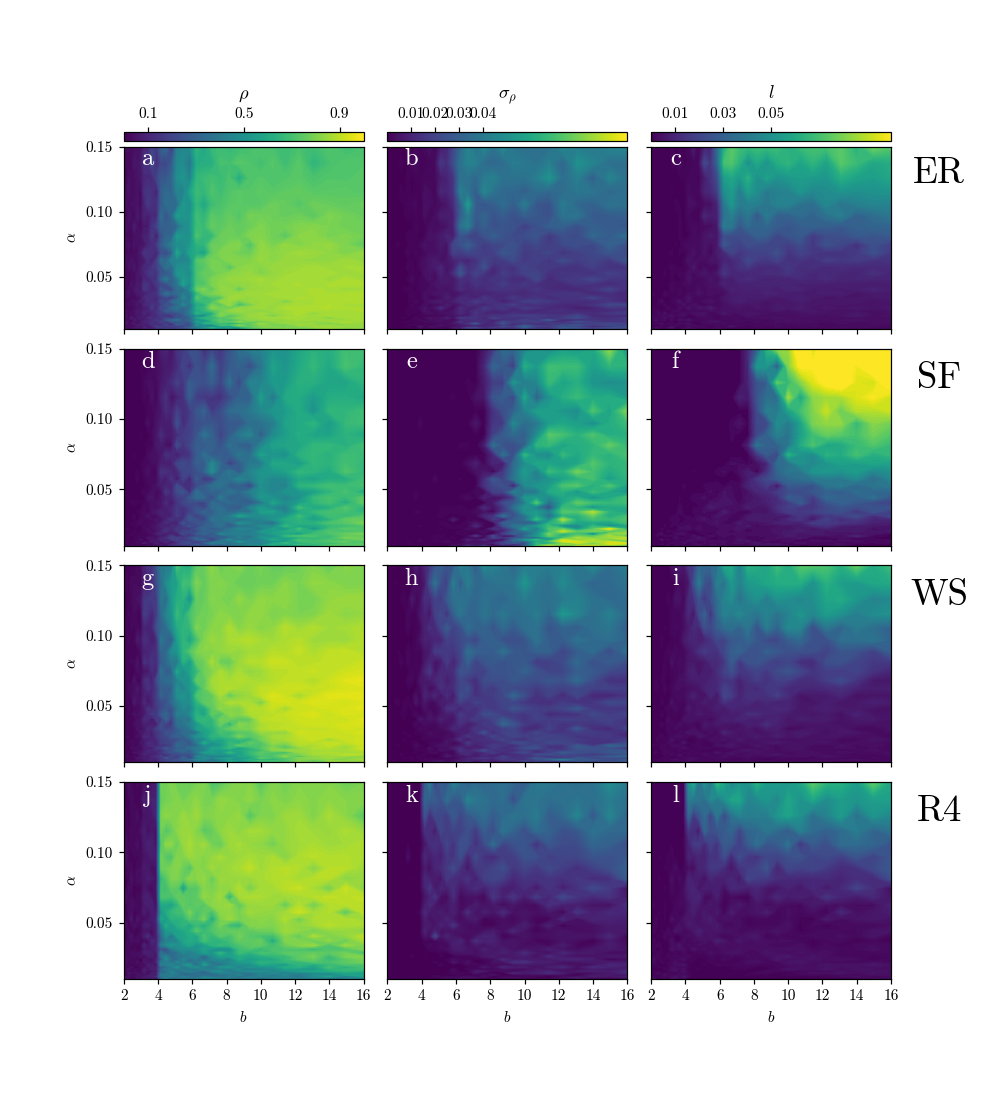

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'label'


In [278]:
plot_2d(alphas, bs, [res_er, res_sf, res_ws, res_four], 1000, ['rho', 'stdrho', 'l'], ['ER', 'SF', 'WS', 'R4'])

In [10]:
bs = np.logspace(np.log(2), np.log(16), base=np.exp(1), num=32)
alphas = np.logspace(np.log(0.01), np.log(0.15), base=np.exp(1), num=32)
n = 100
print(bs)
print(alphas)

[ 2.          2.1387594   2.28714588  2.44582737  2.61551814  2.796982
  2.99103576  3.19855292  3.42046756  3.65777857  3.91155415  4.18293659
  4.47314747  4.7834931   5.11537041  5.47027326  5.84979917  6.25565648
  6.68967204  7.15379947  7.65012792  8.18089148  8.74847927  9.35544612
 10.00452416 10.69863503 11.4409031  12.23466951 13.08350719 13.99123698
 14.96194478 16.        ]
[0.01       0.01091286 0.01190904 0.01299617 0.01418253 0.01547719
 0.01689004 0.01843185 0.02011442 0.02195057 0.02395434 0.02614103
 0.02852733 0.03113147 0.03397332 0.0370746  0.04045897 0.04415229
 0.04818276 0.05258116 0.05738106 0.06261912 0.06833535 0.07457338
 0.08138086 0.08880976 0.09691681 0.10576392 0.11541865 0.12595471
 0.13745256 0.15      ]


In [11]:
def ER(t):
    return ErdosRenyi(*t)

er_graphs = Pool(32).map(ER, [(n, 4. / n)] * 500)

In [12]:
def SF(t):
    return ScaleFree(*t)

sf_graphs = Pool(32).map(SF, [(n, 4)] * 500)

In [14]:
def WS(t):
    return SmallWorld(*t)

ws_graphs = Pool(32).map(WS, [(n, 4, .5)] * 500)

In [15]:
four_graphs = Pool(32).map(GraphByDegrees, [{4: n}] * 500)

In [27]:
import pickle

In [42]:
res = calc('fun', alphas, bs, sf_graphs[:10], 10000, set_builder=total, keys=['rho', 'l'])
with open('res_sf.pkl', 'wb') as f:
    pickle.dump(res, f)

#1 passed in 889.5093183517456,  projected end in 133.42640626430511 minutes
#2 passed in 887.9249472618103,  projected end in 118.49615194002787 minutes
#3 passed in 890.8834166526794,  projected end in 103.76834353738361 minutes
#4 passed in 878.4032475948334,  projected end in 88.6683627128601 minutes
#5 passed in 883.9855329990387,  projected end in 73.84541041056315 minutes
#6 passed in 892.4169909954071,  projected end in 59.14604335361057 minutes
#7 passed in 890.546389579773,  projected end in 44.38353146825518 minutes
#8 passed in 887.060587644577,  projected end in 29.58649375339349 minutes
#9 passed in 899.7825465202332,  projected end in 14.815823648594042 minutes
#10 passed in 887.6052060127258,  projected end in 0.0 minutes
time elapsed = 8891.07056427002


In [40]:
res = calc('fun', alphas, bs, er_graphs[:10], 10000, set_builder=total, keys=['rho', 'l'])
with open('res_er.pkl', 'wb') as f:
    pickle.dump(res, f)

#1 passed in 610.8823001384735,  projected end in 91.63235256671905 minutes
#2 passed in 596.5311713218689,  projected end in 80.494606479009 minutes
#3 passed in 551.3692054748535,  projected end in 68.39744536214405 minutes
#4 passed in 566.7339782714844,  projected end in 58.138293439149855 minutes
#5 passed in 577.2847454547882,  projected end in 48.380324419339495 minutes
#6 passed in 574.6146848201752,  projected end in 38.63819594648149 minutes
#7 passed in 567.3383667469025,  projected end in 28.89129457133157 minutes
#8 passed in 595.2961707115173,  projected end in 19.333679501215617 minutes
#9 passed in 575.2916774749756,  projected end in 9.658111205807439 minutes
#10 passed in 542.2510602474213,  projected end in 0.0 minutes
time elapsed = 5760.00652050972


In [41]:
res = calc('fun', alphas, bs, ws_graphs[:10], 10000, set_builder=total, keys=['rho', 'l'])
with open('res_ws.pkl', 'wb') as f:
    pickle.dump(res, f)

#1 passed in 581.7042713165283,  projected end in 87.25564949512481 minutes
#2 passed in 575.2431652545929,  projected end in 77.13026795387267 minutes
#3 passed in 577.4672288894653,  projected end in 67.44989803897009 minutes
#4 passed in 586.2809329032898,  projected end in 58.01773756146431 minutes
#5 passed in 581.7612285614014,  projected end in 48.37456655899684 minutes
#6 passed in 590.3407123088837,  projected end in 38.80909692181481 minutes
#7 passed in 577.112468957901,  projected end in 29.070959206989833 minutes
#8 passed in 583.1689021587372,  projected end in 19.387944067517918 minutes
#9 passed in 585.8986027240753,  projected end in 9.70186632959931 minutes
#10 passed in 578.7520246505737,  projected end in 0.0 minutes
time elapsed = 5819.886193752289


In [54]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [56]:
res = calc('fun', alphas, bs, four_graphs[:10], 10000, set_builder=total, keys=['rho', 'l'])
with open(addr('res_four'), 'wb') as f:
    pickle.dump(res, f)

#1 passed in 592.670254945755,  projected end in 88.9005498290062 minutes
#2 passed in 592.6263830661774,  projected end in 79.02011793454488 minutes
#3 passed in 583.7423157691956,  projected end in 68.79640186760162 minutes
#4 passed in 582.1982531547546,  projected end in 58.7813337802887 minutes
#5 passed in 598.3684558868408,  projected end in 49.1604241847992 minutes
#6 passed in 587.6291036605835,  projected end in 39.30286651452382 minutes
#7 passed in 589.3401486873627,  projected end in 29.47573110546385 minutes
#8 passed in 582.3704226016998,  projected end in 19.62073923846086 minutes
#9 passed in 587.0012385845184,  projected end in 9.807381104981458 minutes
#10 passed in 582.08682513237,  projected end in 0.0 minutes
time elapsed = 5879.116147994995


In [ ]:
res_sf['l'].shape

In [ ]:
res_er['l'].shape

In [38]:
with open('res_er.pkl', 'rb') as f:
    res_er = pickle.load(f)

with open('res_sf.pkl', 'rb') as f:
    res_sf = pickle.load(f)

with open('res_ws.pkl', 'rb') as f:
    res_ws = pickle.load(f)

with open('res_four.pkl', 'rb') as f:
    res_four = pickle.load(f)

<IPython.core.display.Javascript object>


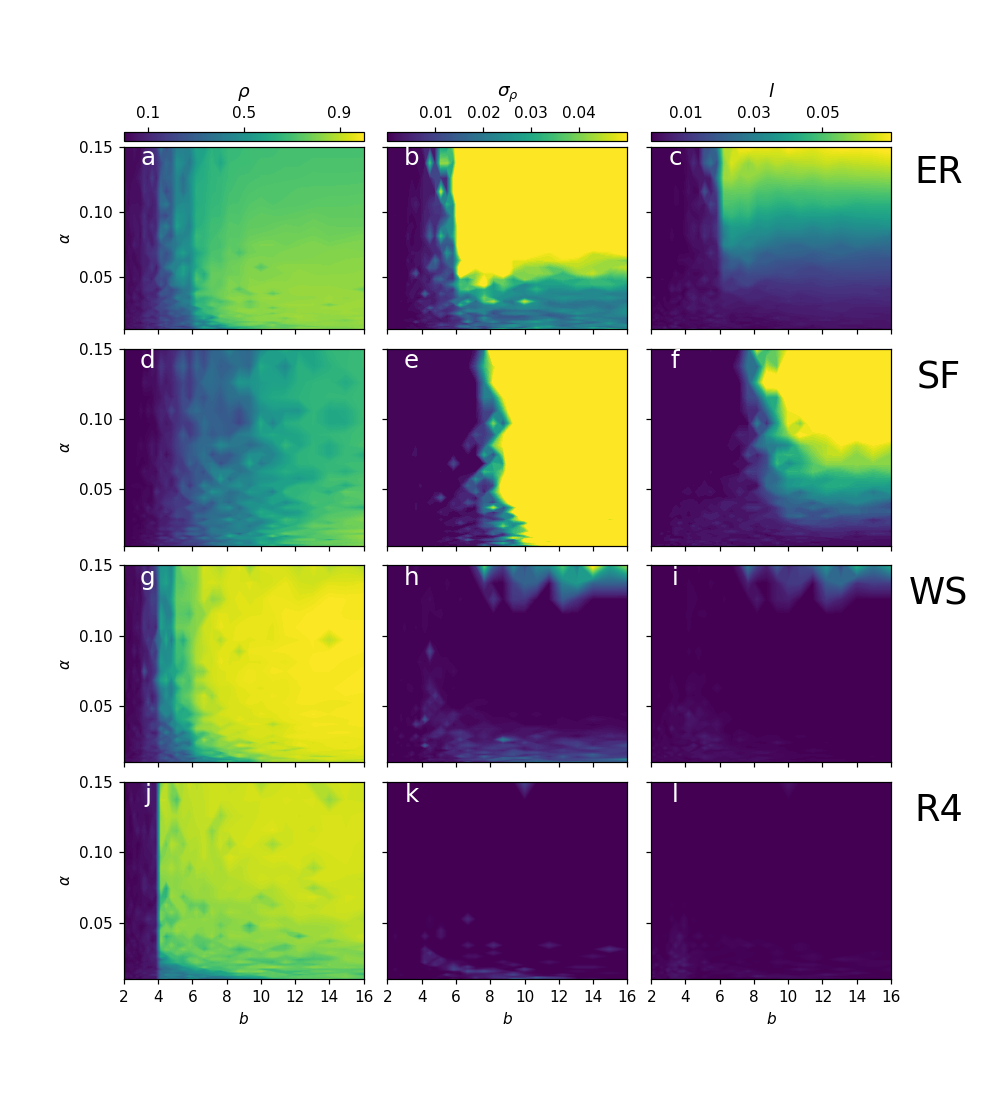

/home/zhuk1996/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'label'


In [57]:
plot_2d(alphas, bs, ['res_er', 'res_sf', 'res_ws', 'res_four'], 1000, ['rho', 'stdrho', 'l'], ['ER', 'SF', 'WS', 'R4'])